In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET

path='drive/MyDrive/RCNN/archive/train_zip/train/'
p=sorted(os.listdir(path))

labels_map = {'apple':1,'banana':2,'orange':3,'mixed':4,}



def preprocessing(x):

  image=cv2.imread(path+p[x])
  scale_x=256/image.shape[1]
  scale_y=256/image.shape[0]
  image = cv2.resize(image, (256,256))
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  img=torch.from_numpy(image.transpose(2,0,1)).float().unsqueeze(0)/255

  tree = ET.parse(path+p[x+1])
  root = tree.getroot()
  xmin = int(root.find("object/bndbox/xmin").text)
  ymin = int(root.find("object/bndbox/ymin").text)
  xmax = int(root.find("object/bndbox/xmax").text)
  ymax = int(root.find("object/bndbox/ymax").text)
  xmin=xmin*scale_x
  ymin=ymin*scale_y
  xmax=xmax*scale_x
  ymax=ymax*scale_y
  name= root.find("object/name").text
  clas=torch.tensor([labels_map[name]]).unsqueeze(0)
  box=torch.tensor([xmin,ymin,xmax,ymax]).unsqueeze(0)
  return [img,clas,box]

list=preprocessing(0)
img=list[0]
label=list[1]
box=list[2]

for i in range(2,len(p)):
  if(i%2==0):
    list=preprocessing(i)
    img=torch.cat([img,list[0]],dim=0)
    label=torch.cat([label,list[1]],dim=0)
    box=torch.cat([box,list[2]],dim=0)











In [3]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels, box, transform=None):
        self.data = data
        self.labels = labels
        self.box=box
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        box=self.box[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, box

dataset=CustomDataset(img,label,box)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

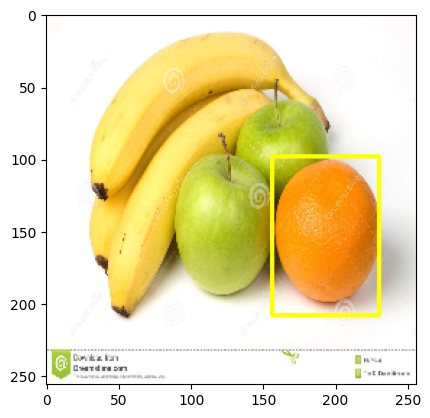

In [14]:

def stampa2(x):
  image=img[x]
  image=image.numpy().transpose(1,2,0)
  image=image.copy()


  xmin = int(box[x][0].item())
  ymin = int(box[x][1].item())
  xmax = int(box[x][2].item())
  ymax = int(box[x][3].item())

  cv2.rectangle(image,(xmin,ymax),(xmax,ymin),color=(255,255,0),thickness=2)
  plt.imshow(image)


stampa2(159)


In [8]:

def generate_anchor_boxes(image_size, ratios, scales):
    anchor_boxes = []
    for ratio in ratios:
        for scale in scales:
            width = scale * torch.sqrt(torch.tensor(ratio))
            height = scale / torch.sqrt(torch.tensor(ratio))
            x_center = torch.arange(0, image_size[1], width)
            y_center = torch.arange(0, image_size[0], height)

            for x in x_center:
                for y in y_center:
                    anchor_boxes.append([x - width / 2, y - height / 2, x + width / 2, y + height / 2])

    return torch.tensor(anchor_boxes)

image_size = (256, 256)        # Dimensioni dell'immagine
ratios = [0.5, 1, 2]            # Rapporti delle anchor boxes
scales = [32,64,128]        # Scale delle anchor boxes
anchor = generate_anchor_boxes(image_size, ratios, scales)




In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Feature_Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x



class FastRCNN(nn.Module):
    def __init__(self):
        super(FastRCNN, self).__init__()
        self.extractor = Feature_Extractor()
        self.roi_pooling = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=294, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=4)
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(in_features=294, out_features=120),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=4)
        )

    def forward(self, x, rois):
        features = self.extractor(x)
        pooled_features = self.roi_pooling(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)

        class_scores = self.classifier(pooled_features)
        bbox_deltas = self.bbox_regressor(pooled_features)

        return class_scores, bbox_deltas




criterion_c = nn.CrossEntropyLoss()
criterion_r= nn.SmoothL1Loss()
model=FastRCNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
dataiter = iter(dataloader)
images,labels,box = next(dataiter)


In [24]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss_c = 0.0
    running_loss_r = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels, box = data
        optimizer.zero_grad()
        outc,outb = model.forward(inputs,anchor)
        loss_c = criterion_c(outc, labels)
        loss_b = criterion_r(outb, box)
        loss_c.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_b.backward()
        optimizer.step()

        # print statistics
        running_loss_c += loss_c.item()
        running_loss_r += loss_b.item()
        if i % 4 == 3:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:3d}] loss_c: {running_loss_c / 5:.3f} loss_b: {running_loss_r}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

In [37]:
for i, data in enumerate(dataloader):
  break
data[2]

tensor([[ 16.2667,  17.0667, 140.2667, 233.2444],
        [  6.4000,  17.2101, 234.7520, 226.7429],
        [ 69.7409,  19.3208, 253.0233, 256.0000],
        [ 31.9488,  41.6914, 161.3824, 256.0000],
        [  7.1680,   5.3895, 142.3360, 188.6316],
        [ 65.0667,  71.8222, 176.8000, 213.3333],
        [ 13.7014,  15.1437, 243.0197, 234.3662],
        [122.1486,  30.8050, 253.0743, 213.5104],
        [139.4215,  17.6177, 246.7446, 130.0663],
        [ 13.3908,  63.7388, 186.4862, 248.8947],
        [ 19.6267,  28.8328, 232.1067, 231.5358],
        [  5.5467,  28.2173, 128.8533, 237.5974],
        [  0.8533,  85.3333, 250.8800, 250.3111],
        [ 36.2338,  50.6047, 241.4277, 163.0340],
        [ 36.8000,  48.9877, 242.0000, 251.2593],
        [ 14.1697,  74.2400, 240.8856, 248.3200],
        [  9.5573,  16.8960, 241.1520, 242.1760],
        [111.8405,  27.5200, 239.8405, 232.3200],
        [117.0541,  30.9581, 226.9599, 186.3442],
        [ 99.7744,  61.2301, 253.7026, 256.0000],
